<a href="https://colab.research.google.com/github/vzinkovski/forecasting_trading_futures_ml_ensembles/blob/main/forecasting_trading_soybean_futures_ml_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting and Trading CME Soybean Futures with ML Ensembles

*Last updated: 02 Feb 2024*

**Introduction**

In financial economics, the efficient market hypothesis (EMH) posits that all available information regarding a given security is reflected in its price. There exists a weak, semi-strong and strong form EMH, but all agree that it is essentially not possible to consistently outperform the market.

While the EMH has been influential in financial theory, it has also faced criticism. Some argue that there are situations where markets are not perfectly efficient, and anomalies do exist. For example, behavioural finance explores how psychological factors can lead to market inefficiencies and deviations from the EMH. Empirically, numerous hedge funds and trading houses, both systematic and discretionary, have also proven capable of outperforming the market over the long run.

**Objective**

In this project we will endeavour to exploit any such inefficiencies in the price and build an ensemble of supervised learning machine models to forecast price returns of CME soybean futures. In contrast to absolute price levels, returns are well-known to be stationary and therefore lend themselves better to modeling.

Our model aims to forecast whether the closing price tomorrow will be higher than today. Naturally, we could extend this methodology and build another model to forecast whether tomorrow's price will be lower than today. However, for brevity, this project will focus on the former. The code, however, is easily extendable to the latter scenario.

Once our model has been built and tuned, we then develop a simple trading strategy. If we predict tomorrow's price to close higher, we enter a long position for a holding period of just one day. Finally, we evaluate the performance of this strategy versus an outright buy-and-hold strategy.

Note that our model can equally be applied in forecasting returns for other commodities futures contracts, stocks, currency pairs, etc.

## Libraries

In [1]:
%%capture

# install missing libraries
!pip install watermark # record dependencies

In [2]:
%%capture

# standard libraries
import numpy as np
import pandas as pd
import scipy.stats

# machine learning libraries
import lightgbm as lgb
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, precision_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb

# visualisation libraries
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# api libraries
import yfinance as yf

# utility
import warnings

In [3]:
# pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# other display
warnings.filterwarnings("ignore", category=Warning)

## Load data

We use the Yahoo! Finance API to download daily OHLC and volume data for CME soybean futures starting from Sep 2000 until present.

In [4]:
# define commodity futures contract
ticker = 'ZS=F' # cme soybeans
ticker_name = 'soybean'

# define date range for download
start_date = '2000-09-15'
end_date = '2024-02-02'

# download ohlc price and volume data
main_df = yf.download([ticker], start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


## Preprocess data

We remove uninformative columns and check for missing values and outliers, as well as inspect key summary statistics such as mean, min and max values to ensure that our data is orderly.

In [5]:
# drop uninformative columns
main_df.drop('Close', axis=1, inplace=True)

# rename columns for convenience
main_df.rename(columns={'Adj Close': 'Close'}, inplace=True)

In [6]:
# check missing values
main_df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [7]:
# check outliers
main_df.describe()

,Open,High,Low,Close,Volume
count,5881.00,5881.00,5881.00,5881.00,5881.00
mean,1002.41,1012.02,993.93,1002.77,49954.11
std,337.55,342.63,332.67,337.54,55157.36
min,418.00,418.50,418.00,418.50,0.00
25%,750.50,757.50,744.50,751.00,755.00
50%,971.25,981.00,964.50,971.50,23499.00
75%,1309.00,1321.75,1295.50,1308.25,95572.00
max,1778.50,1794.75,1760.50,1771.00,352462.00


In [8]:
# check duplicate dates
main_df.duplicated().sum()

0

### Define train validation test date ranges

We have approximately 24 years worth of data. Commonly 20-25% is set aside for validation and testing. As such, we use 18 year's worth of data to train our model, 3 years to validate and tune our model, and the remaining 3 years to perform one final model evaluation against the holdout test set.

In [9]:
# specify training and validation date ranges
end_train_date = '2017-12-31'
end_valid_date = '2020-12-31'

### Define target variable

In order to define our target variable, we first compute daily percentage changes in closing prices. For all values above zero percent, we label these as our positive class 1. All other values are our negative class 0. This is in line with convention within the machine learning community. The labels 1 and 0 have no particular meaning and we could have alternatively labeled these as 1 and -1. Note that if we were trying to forecast negative returns, all we would need to do is simply reverse the class labels where all down days are labeled as the positive class 1.

Next, to convert our time series problem into a supervised learning problem, we define the CME soybeans returns at timestep $t_{+1}$ as our target variable $y$. This requires backshifting our categorical class returns column which also ensures we avoid any lookahead.

In [10]:
# define spread categorical classes
main_df['return_1t'] = main_df['Close'].pct_change() * 100
main_df['return_class'] = main_df['return_1t'].apply(lambda x: 1 if x > 0 else 0)

# create target variable y
main_df['y'] = main_df['return_class'].shift(-1)

# drop missing rows
main_df.dropna(inplace=True)

### Check class imbalance

Given the stationary nature of price returns, we would expect these to have a mean centred around zero and constant variance over time. A visual inspection of the below plot confirms this to be the case.

Additionally, this also implies that our positive and negative classes will be balanced. Different literature will give different definitions of what a balanced class distribution should look like. Our data is distributed roughly 51.5% positive vs. 48.5% negative. Even by the strictest definitions this is considered balanced as it provides our machine learning models with a representative number of observations in each class so that they are able to learn how to discriminate effectively.

Note that we perform the class balance check strictly over the training and validation portion of our data only in order to avoid lookahead. The test set needs to remain as strictly unseen data until final model evaluation.

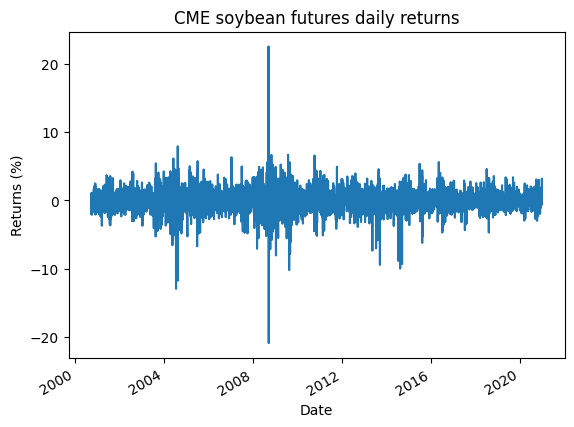

In [11]:
# display stationarity of returns
main_df['return_1t'][:end_valid_date].plot()
plt.title('CME soybean futures daily returns')
plt.ylabel('Returns (%)')
plt.show()

# clean up column
main_df.drop('return_1t', axis=1, inplace=True)

In [12]:
# check class imbalance
print(f"""
    Positive class: {main_df['y'][:end_valid_date].value_counts(normalize=True)[1]:.4f}
    Negative class: {main_df['y'][:end_valid_date].value_counts(normalize=True)[0]:.4f}
""")


    Positive class: 0.5150
    Negative class: 0.4850



## Feature engineering

In order to extract more information from the data we have at hand, we perform various feature engineering steps.

First, we compute returns between the current closing price and the closing price of the preceding observation. Then between the current closing price and that of two observations ago. We step back in this fashion 10 observations, i.e. two calendar weeks. We perform this same computation for the open, high, low and volume features stepping back up to 5 observations. This allows us to capture the evolution of various absolute values over time expressed in percentage terms.

Second, we consider rolling statistics of one day returns. We calculate the mean, standard deviation, minimum and maximum for 5, 10, 20, 30 and 40-day window lengths. This allows us to retain past information about one day returns and carry these metrics forward into the current observation.

Third, we take one day returns, as well as whether those returns were labeled as the positive or negative class, and then take lagged values of these two features stepping back up to 10 observations. In other words, we transform past values of the target variable into additional explanatory variables.

Lastly, we calculate a number of custom features, all of which aim to capture the relative performance of one day returns over various lookback periods. The logic is that stationary returns are mean reverting and thus if, for example, returns have been negative relative to their recent range for a number of periods, they are more likely to be positive in consequent periods.
- The min-max range of one day returns on a 5, 10, 20, 30 and 40-day rolling basis
- Moving average crossovers (similar to MACD) of one day returns for 5, 10 and 20-day windows
- Oscillator (similar to RSI) of one day returns versus the maximum one day returns obtained from a 5, 10, 20, 30 and 40-day lookback window
- Z-scores of one day returns over 5, 10, 20, 30 and 40-day periods

### Return features

In [13]:
def return_features(df, columns, periods):

    # compute percentage changes between periods
    for period in range(1, periods+1):
        new_cols = [f'{col}_return_{period}t' for col in columns]
        df[new_cols] = df[columns].pct_change(periods=period)

    return df

### Rolling features

In [14]:
def rolling_features(df, columns, windows):

    # define column names
    mean_cols = [f'{col}_mean' for col in columns]
    std_cols = [f'{col}_std' for col in columns]
    min_cols = [f'{col}_min' for col in columns]
    max_cols = [f'{col}_max' for col in columns]

    # create rolling mean, std, min and max features
    for window in windows:

        mean_colnames = [f'{col}_{window}t' for col in mean_cols]
        df[mean_colnames] = df[columns].rolling(window=window).mean()

        std_colnames = [f'{col}_{window}t' for col in std_cols]
        df[std_colnames] = df[columns].rolling(window=window).std()

        min_colnames = [f'{col}_{window}t' for col in min_cols]
        df[min_colnames] = df[columns].rolling(window=window).min()

        max_colnames = [f'{col}_{window}t' for col in max_cols]
        df[max_colnames] = df[columns].rolling(window=window).max()

    return df

### Lagged features

In [15]:
def lagged_features(df, columns, lags):

    # create features containing lagged values
    for lag in range(1, lags+1):
        new_cols = [f'{col}_t-{lag}' for col in columns]
        df[new_cols] = df[columns].shift(periods=lag)

    return df

### Custom features

In [16]:
def custom_features(df):

    # add max-min range features
    df['Close_return_5t_min_max_range'] = df['Close_return_1t_max_5t'] - df['Close_return_1t_min_5t']
    df['Close_return_10t_min_max_range'] = df['Close_return_1t_max_10t'] - df['Close_return_1t_min_10t']
    df['Close_return_20t_min_max_range'] = df['Close_return_1t_max_20t'] - df['Close_return_1t_min_20t']
    df['Close_return_30t_min_max_range'] = df['Close_return_1t_max_30t'] - df['Close_return_1t_min_30t']
    df['Close_return_40t_min_max_range'] = df['Close_return_1t_max_40t'] - df['Close_return_1t_min_40t']

    # add moving average crossover features
    df['Close_return_long_med_macd'] = df['Close_return_1t_mean_20t'] - df['Close_return_1t_mean_10t']
    df['Close_return_long_short_macd'] = df['Close_return_1t_mean_20t'] - df['Close_return_1t_mean_5t']
    df['Close_return_med_short_macd'] = df['Close_return_1t_mean_10t'] - df['Close_return_1t_mean_5t']

    # add oscillator features
    df['Close_return_5t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_5t']
    df['Close_return_10t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_10t']
    df['Close_return_20t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_20t']
    df['Close_return_30t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_30t']
    df['Close_return_40t_rsi'] = df['Close_return_1t'] / df['Close_return_1t_max_40t']

    # add z-score features
    df['Close_return_5t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_5t']) / df['Close_return_1t_std_5t']
    df['Close_return_10t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_10t']) / df['Close_return_1t_std_10t']
    df['Close_return_20t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_20t']) / df['Close_return_1t_std_20t']
    df['Close_return_30t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_30t']) / df['Close_return_1t_std_30t']
    df['Close_return_40t_zscore'] = (df['Close_return_1t'] - df['Close_return_1t_mean_40t']) / df['Close_return_1t_std_40t']

    return df

## Augment dataset

In [17]:
# number of periods and list of features for which to calculate returns
return_periods_far = 10
return_cols_far = ['Close']
return_periods_near = 5
return_cols_near = ['Open', 'High', 'Low', 'Volume']

# window horizons and list of features for which to calculate rolling statistics
rolling_windows = [5, 10, 20, 30, 40]
rolling_cols = ['Close_return_1t']

# number of lags and list of features on which to perform lagged operation
lagged_periods = 10
lagged_cols = ['Close_return_1t', 'return_class']

In [18]:
def feature_engineering(df):

    # feature engineering steps to perform sequentially
    df = return_features(df, return_cols_far, return_periods_far)
    df = return_features(df, return_cols_near, return_periods_near)
    df = rolling_features(df, rolling_cols, rolling_windows)
    df = lagged_features(df, lagged_cols, lagged_periods)
    df = custom_features(df)

    return df

In [19]:
# run main df through our custom feature engineering pipeline
main_df = feature_engineering(main_df)

# display dataframe size
print(f'DataFrame rows by columns: {main_df.shape}')

DataFrame rows by columns: (5879, 95)


### Drop uninformative features

We drop all absolute value features as these by themselves do not tell us much about whether today's returns will be up or down. Rather, what we are interested in are ratios and features which capture the historical evolution of absolute values - which is exactly the type of information we extracted in the preceding feature engineering section.

In [20]:
# drop uninformative absolute value features
prices = main_df['Close'] # keep variable for later plotting
main_df.drop((return_cols_near + ['Close']), axis=1, inplace=True)

### Handle missing values

We replace all infinite values which could have resulted from a division by zero with missing values, then forward fill missing values to avoid lookahead, and finally drop observations which contain any remaining missing values (in our case these are only the first $n$-days from computing rolling statistics).

In [21]:
# handle missing values
main_df.replace([np.inf, -np.inf], np.nan, inplace=True)
main_df.ffill(inplace=True)
main_df.dropna(inplace=True)

## Train validation test split

Now we partition our data set into a training, validation and test set.

The training set will be used to tune our hyperparameters via time series cross validation, and then assess the in-sample performance for both the individual models and ensemble model.

The validation set will first be used to evaluate the out-of-sample performance of the ensemble model, and then used to adjust the classification threshold in order to obtain higher precision.

Lastly, we retrain our ensemble model on the combined train and validation sets, then perform a final evaluation of the ensemble on the test set.

In [22]:
# partition main df into train validation test sets
train_df = main_df[:end_train_date]
valid_df = main_df[end_train_date:end_valid_date]
train_valid_df = main_df[:end_valid_date]
test_df = main_df[end_valid_date:]

# split training data into X and y
X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

# split validation data into X and y
X_valid = valid_df.drop('y', axis=1)
y_valid = valid_df['y']

# split training+validation data into X and y
X_train_valid = train_valid_df.drop('y', axis=1)
y_train_valid = train_valid_df['y']

# split test data into X and y
X_test = test_df.drop('y', axis=1)
y_test = test_df['y']

## Set up pipeline

This part adds a simple, yet robust, machine learning pipeline preprocessing step that performs median imputation of missing values and standard scaling for numerical features, as well as most-frequent imputation of missing values and one-hot encoding for categorical features.

Although we do not have any categorical features in our current dataset, adding this piece of code would allow us to easily incorporate such features. An example of using categorical input features could be as simple as taking lagged values of the target variable in case of a multiclass classification problem.

Each of our individual models are instantiated with this preprocessing pipeline step embedded.

In [23]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent', add_indicator=True),
    OneHotEncoder(drop='first', handle_unknown='ignore'),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude='category')),
    (categorical_transformer, make_column_selector(dtype_include='category')),
)

## Instantiate models

Generally speaking, when creating an ensemble, more models is better. However, more specifically, we are interested in ensembling models which make slightly different predictions and therefore different errors. If all models make the same errors, ensembling them will not result in better prediction as the ensemble will keep making the same mistakes with no opportunity to average these out.

Diversity can be achieved by combining different families of machine learning algorithms. For the sake of brevity, we limit our ensemble to four different individual models:
- Logistic regression, a parametric, linear model
- K-nearest neighbours, a non-parametric, non-linear model
- XGBoost, a gradient boosted tree-based model which uses a depth-first growth approach (i.e. deeper trees with fewer branches)
- LightGBM, a gradient boosted tree-based model which uses a level-wise growth approach (i.e. more shallow trees with more branches)

Note that the last two models are both tree-based and share many similarities, but can nevertheless be considered distinct as they use a different splitting algorithm under the hood.

### Logistic regression

In [24]:
# instantiate pipeline with logistic regression
logreg_clf = make_pipeline(
    preprocessor,
    LogisticRegression(
        random_state=42,
        n_jobs=-1,
    ),
)

# hyperparameter search space for logistic regression model
logreg_clf_params = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': scipy.stats.reciprocal(0.01, 100),
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__solver': ['liblinear', 'saga']
}

### KNN classifier

In [25]:
# instantiate pipeline with knn classifier
knn_clf = make_pipeline(
    preprocessor,
    KNeighborsClassifier(n_jobs=-1),
)

# hyperparameter search space for knn classifier model
knn_clf_params = {
    'kneighborsclassifier__n_neighbors': scipy.stats.randint(5, 51),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1.0, 1.5, 2.0],
}

### XGBoost classifier

In [26]:
# instantiate xgboost classifier
xgb_clf = make_pipeline(
    preprocessor,
    xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        objective='binary:logistic',
        importance_type='gain',
        verbosity=0,
        n_jobs=-1,
    )
)

# hyperparameter search space for xgboost classifier model
xgb_clf_params = {
    'xgbclassifier__max_depth': scipy.stats.randint(2, 11),
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'xgbclassifier__reg_alpha': [0., 0.1, 0.25, 0.5, 1.0, 1.5],
    'xgbclassifier__reg_lambda': [0., 0.25, 0.5, 1.0, 1.5, 2.0],
}

### LightGBM classifier

In [27]:
# instantiate lightgbm classifier
lgb_clf = make_pipeline(
    preprocessor,
    lgb.LGBMClassifier(
        n_estimators=100,
        random_state=42,
        objective='binary',
        importance_type='gain',
        verbosity=-1,
        n_jobs=-1,
    )
)

# hyperparameter search space for lightgbm classifier model
lgb_clf_params = {
    'lgbmclassifier__num_leaves': [16, 32, 64],
    'lgbmclassifier__learning_rate': [0.01, 0.1, 0.15],
    'lgbmclassifier__min_child_samples': scipy.stats.randint(10, 31),
    'lgbmclassifier__reg_alpha': [0., 0.1, 0.25, 0.5, 1.0, 1.5],
    'lgbmclassifier__reg_lambda': [0., 0.25, 0.5, 1.0, 1.5, 2.0],
}

# Training

## Hyperparameter tuning

We perform hyperparameter tuning for each of the individual models using a time series cross validation approach. The cross validation is a walk-forward validation where each successive training fold is a superset of the previous folds. This is to avoid introducing lookahead where we train our model on future unseen data. We opt to use 4-fold cross validation, where each test fold contains 252 trading days (i.e. one calendar year). Usually, 5-fold cross validation is performed, however both our validation and test sets contain 3 year's worth of data each and hence we select a value in between which should guarantee both robustness and representativeness.

For this project, we decided to use a randomised grid search to find the best hyperparameter combination. Although this is better than an exhaustive grid search, which fails to consider the subspace between the predefined hyperparameters, it is nevertheless not as efficient at finding the optimum hyperparameter combination as a Bayesian optimisation algorithm. Our reason for choosing a randomised approach is because it is less computationally demanding than Bayesian optimisation and thus faster to execute. Considering we are tuning 4 models, across 4 validation folds, using 30 iterations with different hyperparameter combinations, this results in fitting 480 models - hence the preference for a method with faster computation. It must be said, however, that all three of these parts can be parallelised and thus allocating more resources can alleviate the problem.

For each individual model, we explicitly define all hyperparameters to be considered based on a priori knowledge. However, we present one hyperparameter in each model as a distribution, which enables the randomised search algorithm to resample hyperparameter combinations with replacement.

Finally, we specify the performance metric to be maximised as precision. Precision is simply $TP$ / ($TP$+$FP$), where $TP$ is true positives and $FP$ is false positives. In other words, precision answers the question: "out of the predicted positive instances, how many were truly positive?".

In [28]:
# time series cross validation
tscv = TimeSeriesSplit(n_splits=4, test_size=252) # four test folds of approx one year each

In [29]:
def tune_hyperparams(estimator, param_dist, name, display=True):

    # perform a randomised grid search with 30 iterations
    rscv = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=30, # this number is shown empirically to work well
        scoring='precision',
        cv=tscv,
        verbose=0,
        random_state=42,
    )

    # fit randomised grid search cv object to training data
    rscv.fit(X_train, y_train)

    if display:

        # display best hyperparameter combo
        print(f'Best hyperparameters for {name}')
        print('- - -')
        for param, value in rscv.best_params_.items():
            print(f'{param}: {value}')

        # display performance metrics
        print(f"""
        Cross-validated precision score
        - - -
        Mean: \t\t{rscv.cv_results_['mean_test_score'][rscv.best_index_]:.3f}
        Std dev: \t{rscv.cv_results_['std_test_score'][rscv.best_index_]:.3f}
        """)

    return rscv.best_estimator_

### Individual model evaluation

The below cross-validated precision scores are all above 0.5, which means each individual model is able to correctly predict the positive class in more than half of the instances. The interpretation of whether this score can be considered good or bad is highly domain specific. For example, in medical image diagnosis, if for each time our model diagnosed a patient with disease it was correct in only roughly half those instances, we would consider this a very poor model. However, in financial time series, and given their random walk nature, a model which is consistently able to correctly predict market direction in more than half of the cases might actually be considered for further development into a potential systematic trading strategy.

We also note that, unsurprisingly, the gradient boosted decision trees (GBDT) - which are more complex models and ensembles in their own right - had higher precision and lower standard deviation in their predictions compared to the other models. However, in accordance with the no free lunch theorem, the trade-off is that training time for GBDTs generally takes longer, and in our case specifically took about twice as long for the XGBoost model.

Lastly, naively predicting the positive class for each instance would have resulted in a precision score of 0.515. By comparison, at this stage, none of our individual models thus seem particularly successful. The next section looks at whether an ensemble model can in fact be more powerful than the sum of its parts.

In [30]:
print(f"""
    Always predicting the positive class on the training set
    gives us a precision score of: {y_train.value_counts(normalize=True)[1]:.3f}
""")


    Always predicting the positive class on the training set
    gives us a precision score of: 0.515



In [31]:
%%time
logreg_clf_tuned = tune_hyperparams(logreg_clf, logreg_clf_params, 'Logistic Regression Classifier')

Best hyperparameters for Logistic Regression Classifier
- - -
logisticregression__C: 0.0838639478040256
logisticregression__class_weight: balanced
logisticregression__penalty: l1
logisticregression__solver: saga

        Cross-validated precision score
        - - -
        Mean: 		0.509
        Std dev: 	0.046
        
CPU times: user 1min 50s, sys: 10.1 s, total: 2min
Wall time: 1min 57s


In [32]:
%%time
knn_clf_tuned = tune_hyperparams(knn_clf, knn_clf_params, 'KNN Classifier')

Best hyperparameters for KNN Classifier
- - -
kneighborsclassifier__n_neighbors: 7
kneighborsclassifier__p: 1.0
kneighborsclassifier__weights: uniform

        Cross-validated precision score
        - - -
        Mean: 		0.508
        Std dev: 	0.028
        
CPU times: user 2min 11s, sys: 571 ms, total: 2min 11s
Wall time: 1min 14s


In [33]:
%%time
xgb_clf_tuned = tune_hyperparams(xgb_clf, xgb_clf_params, 'XGBoost Classifier')

Best hyperparameters for XGBoost Classifier
- - -
xgbclassifier__learning_rate: 0.1
xgbclassifier__max_depth: 6
xgbclassifier__reg_alpha: 0.1
xgbclassifier__reg_lambda: 1.0

        Cross-validated precision score
        - - -
        Mean: 		0.512
        Std dev: 	0.034
        
CPU times: user 6min 24s, sys: 2.22 s, total: 6min 26s
Wall time: 3min 27s


In [34]:
%%time
lgb_clf_tuned = tune_hyperparams(lgb_clf, lgb_clf_params, 'LightGBM Classifier')

Best hyperparameters for LightGBM Classifier
- - -
lgbmclassifier__learning_rate: 0.1
lgbmclassifier__min_child_samples: 13
lgbmclassifier__num_leaves: 32
lgbmclassifier__reg_alpha: 1.5
lgbmclassifier__reg_lambda: 1.0

        Cross-validated precision score
        - - -
        Mean: 		0.512
        Std dev: 	0.036
        
CPU times: user 3min 27s, sys: 966 ms, total: 3min 28s
Wall time: 1min 52s


## Ensembling models

In order to combine our individual models into one final voting ensemble classifier, we use a soft voting approach. Soft voting involves combining the predicted probabilities of multiple models and selecting the class with the highest average probability as the final prediction. In contrast to hard voting, which only relies on majority class decisions, this method allows us to more fully leverage the inherent uncertainty or confidence each model has in its predictions.

In [35]:
# collect classifier models into a list
estimators = [
    ("logreg_clf", logreg_clf_tuned),
    ("knn_clf", knn_clf_tuned),
    ("xgb_clf", xgb_clf_tuned),
    ("lgb_clf", lgb_clf_tuned),
]

In [36]:
# instantiate voting classifier ensemble model
voting_clf  = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1,
)

### Voting classifier evaluation

Once we have obtained the best hyperparameters for each individual model, we can then combine these into one ensemble. We fit the ensemble on the training data and run the same time series cross validation as described earlier.

The resulting precision score is 0.516, which is better than any of the individual models and also better than the naive approach. Additionally, the standard deviation is 0.028, which is as low as the lowest standard deviation achieved among any of the individual models. So far, evaluated on in-sample training data, ensembling models has performed as intended and produced a more powerful combined model.

In [37]:
%%time

# compute mean cross-validated precision score
scores = cross_val_score(
    estimator=voting_clf,
    X=X_train,
    y=y_train,
    scoring='precision',
    cv=tscv,
    n_jobs=-1,
)

# display mean and std of voting classifier
print(f"""
    Cross-validated precision score
    of voting classifier ensemble
    - - -
    Mean: \t{scores.mean():.3f}
    Std dev: \t{scores.std():.3f}
""")


    Cross-validated precision score
    of voting classifier ensemble
    - - -
    Mean: 	0.516
    Std dev: 	0.028

CPU times: user 155 ms, sys: 78.6 ms, total: 234 ms
Wall time: 21.3 s


# Validation

Here we move into the next stage of model tuning. Specifically, we will adjust the classification threshold such that we further maximise precision whilst making sure that the model is still able to generate an appropriate number of trading signals.

Because we have already used the training set to tune our hyperparameters, we should not use it again to tune our classification threshold. This is in order to avoid the risk of overfitting to the training data.

We first observe some key performance metrics of our voting ensemble classifier on the evaluation data set. Using the default classification threshold of 0.5, we achieve a precision of 0.534. A buy signal is generated on approximately 58% (436/756) of trading days.

Setting a higher classification threshold will generally result in higher precision as our model will need to be more confident before it labels a prediction as the positive class. Consequently, this will also result in fewer trading signals. Both properties have desirable side effects, reflected in a higher percentage of winning trades, and lower commissions by way of not overtrading, respectively.

In the next section we inspect the precision-recall curve, which will help us determine the optimum classification threshold over the validation data set.

In [38]:
%%capture

# fit voting classifier on training set
voting_clf.fit(X_train, y_train)

In [39]:
def adjust_threshold(X, y, train_valid_test, threshold=0.5):

    # use voting classifier to predict
    y_pred = voting_clf.predict_proba(X)[:, 1]
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0

    # show metrics
    print(f"""
        VOTING CLASSIFIER ENSEMBLE
        Performance metrics on {train_valid_test} set
        - - -
        Classification threshold: \t{threshold}
        Precision score: \t\t{precision_score(y, y_pred):.3f}
        # of trading signals: \t\t{int(sum(y_pred))}
        # of total trading days: \t{len(y)}
    """)

In [40]:
# performance metrics on validation set with default threshold
adjust_threshold(X_valid, y_valid, 'validation')


        VOTING CLASSIFIER ENSEMBLE
        Performance metrics on validation set
        - - -
        Classification threshold: 	0.5
        Precision score: 		0.534
        # of trading signals: 		436
        # of total trading days: 	756
    


## Precision recall curve

The precision-recall curve tells us the trade-off between these two metrics. We have defined precision earlier. Recall is simply $TP$ / ($TP$+$FN$), where $FN$ is false negatives. In simpler terms, recall answers the question: "out of all the positive instances, how many did the model manage to find and correctly identify?".

The difference between precision and recall is only in the denominator, where false positives are substituted for false negatives. In practice, this means that if we want to achieve higher precision, we will need to sacrifice recall (and vice-versa), thereby necessarily identifying fewer positive instances.

The below plot is a custom version of the traditional precision-recall curve, where we use twin x-axes showing the score for each metric, whilst the y-axis denotes the trade-off at various classification thresholds.

Whilst it may seem counterintuitive that precision drops to zero as we increase the threshold, we have to remember that we are working with very low signal-to-noise data. At higher thresholds, we label fewer instances as positive, thereby increasing the metric's variance. Given the very low signal, there is still a fairly high chance of getting a prediction wrong, despite the higher confidence in the prediction. Getting a prediction wrong when there are only very few predictions made in all thus results in widely fluctuating precision scores at higher thresholds. Ultimately, setting a precision threshold too high means not classifying a single instance as positive and a precision score of zero.

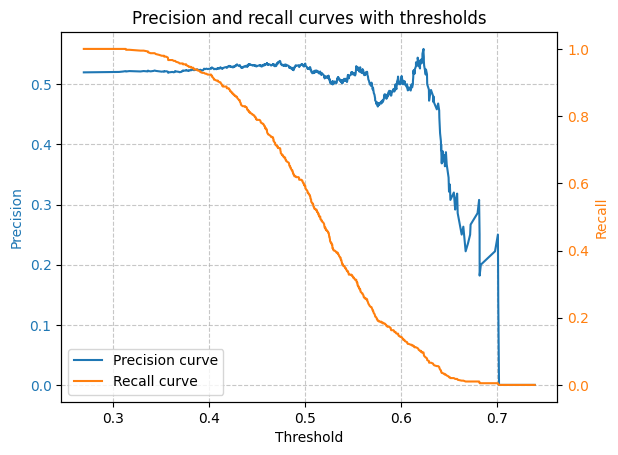

In [41]:
# predict probabilities for the validation set
y_pred = voting_clf.predict_proba(X_valid)[:, 1]

# calculate precision-recall pairs and thresholds
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred)

# plot precision against thresholds
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Precision', color=color)
ax1.plot(thresholds, precision[:-1], label='Precision curve', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# create a secondary y-axis for recall
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Recall', color=color)
ax2.plot(thresholds, recall[:-1], label='Recall curve', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# add gridlines
ax1.grid(True, linestyle='--', alpha=0.7)

# combine legends for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left')

# show plot
plt.title('Precision and recall curves with thresholds')
plt.show()

## Adjust classification threshold

From the above chart we see that the threshold which achieves the highest precision score on the validation data set is around 0.62. In the following code cell, we manually set this as our new classification threshold for our ensemble model, to be applied to the test data set and any other future unseen data.

There is of course a programmatic way to obtain the exact threshold which maximises precision, however the reason for doing this manually is because the precision curve is non-monotonic and we are interested in finding the optimum balance between precision and recall. In practice, setting a threshold which gives us the highest precision might actually result in so few trades that our trading strategy turns out to be less profitable on average. As a hypothetical example, we would rather make 10 trades with 60% precision, than 1 trade with 65% precision, especially considering there is still a 35% chance of getting that 1 trade incorrect. Whereas, as we increase the number of trades, we allow the law of large numbers to take effect.

We can see that adjusting the threshold from the default 0.5 to 0.62 resulted in the precision score improving from 0.534 to 0.541. The trade-off is that we decreased the number of trades from 436 to 74.

In [42]:
# performance metrics on validation set with adjusted threshold
new_threshold = 0.62
adjust_threshold(X_valid, y_valid, 'validation', new_threshold)


        VOTING CLASSIFIER ENSEMBLE
        Performance metrics on validation set
        - - -
        Classification threshold: 	0.62
        Precision score: 		0.541
        # of trading signals: 		74
        # of total trading days: 	756
    


# Testing

Having tuned the hyperparameters of the individual models on the training data, then having adjusted the classification threshold of our ensemble model on the validation data, our model is now ready for a final evaluation on the holdout test data.

In order to evaluate our final ensemble model, we first compare its performance to a benchmark dummy classifier, and then assess its trading performance versus a simple buy-and-hold strategy.

In [43]:
%%capture

# fit voting classifier on training set
voting_clf.fit(X_train_valid, y_train_valid)

## Dummy classifier

We specify the dummy classifier to always predict the positive class. This achieves a precision score of 0.538 on the test set. It also generates a buy signal for every single trading day, thus resulting in a low winning trade percentage (i.e. high false positive rate).

Note that the dummy classifier has no learned parameters and consequently does not require a classification threshold.

In [44]:
# instantiate and fit dummy classifier on training+validation set
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(X_train_valid, y_train_valid)

# use dummy classifier to predict on test set
y_pred = dummy_clf.predict(X_test)

# show metrics
print(f"""
        DUMMY CLASSIFIER
        Performance metrics on test set
        - - -
        Precision score: \t\t{precision_score(y_test, y_pred):.3f}
        # of trading signals: \t\t{int(sum(y_pred))}
        # of total trading days: \t{len(y_test)}
    """)


        DUMMY CLASSIFIER
        Performance metrics on test set
        - - -
        Precision score: 		0.538
        # of trading signals: 		775
        # of total trading days: 	775
    


## Voting classifier

Our voting classifier ensemble achieves a precision score of 0.55 on the test set, which is higher than on both the training and validation sets. Importantly, this is also an improvement over the benchmark dummy classifier.

We generate a buy signal on approximately 10% of all trading days (80/775).

In [45]:
# use voting classifier to predict on test set
y_pred = voting_clf.predict_proba(X_test)[:, 1]
y_pred[y_pred >= new_threshold] = 1
y_pred[y_pred < new_threshold] = 0

In [46]:
# performance metrics on test set with adjusted threshold
adjust_threshold(X_test, y_test, 'test', new_threshold)


        VOTING CLASSIFIER ENSEMBLE
        Performance metrics on test set
        - - -
        Classification threshold: 	0.62
        Precision score: 		0.550
        # of trading signals: 		80
        # of total trading days: 	775
    


## Confusion matrix

The confusion matrix shows us that we had 36 false positives (top right), i.e. we predicted positive returns, but instead returns were negative for that day. The model had 44 true positives (bottom right), thus giving us a precision score of 44 / (36+44) equals 0.55.

Although this is a good result, it does not reflect the magnitude of the returns on a given day, only the directionality. In other words, we could have had 9 correct predictions with a daily return of 1% each time, only to lose money because of 1 incorrect prediction which had a daily return of 10%.

Given a large enough number of trades, we might expect these magnitudes to even out both ways. However, an unfortunate series of wrong predictions with significant magnitude might also result in a wipe out of account equity.

In order to get some sense of how our model would have performed if allocated equity, we will consider a simple trading strategy in the next section.

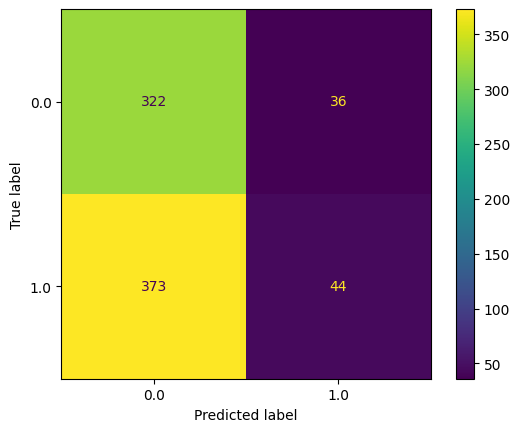

In [47]:
# display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Trading strategy

Our trading strategy has a holding period of only one day and we always allocate 100% of our equity to each trade. Needless to say, this is an oversimplification and a more sophisticated strategy would introduce varying holding periods and position sizing, as well take into account other factors such as market volatility and macroeconomic factors.

Note that our ensemble model only predicts whether returns are positive or not. This is not the same as predicting whether returns are positive or negative. The distinction is subtle, but our model is optimised to predict the positive class, ignoring its performance on the negative class. This is evident from the precision score formula which does not consider true/false negatives in its calculation.

As such, we title our trading strategy as a long-only trading strategy and compare its performance against a benchmark strategy which is an even simpler buy-and-hold.

The below equity curve chart shows the relative performance of these two strategies against each other. We observe that our strategy was far less volatile, which is desirable and would imply a higher Sharpe ratio, as well as being more profitable overall. Although not at all impressive, it achieved an approximate positive 2% cumulative return on equity over 3 years, whereas the buy-and-hold approach would have resulted in an approximate negative 8% cumulative return over the same period. This does not take into account transaction costs, which would be higher for our long-only strategy.

In [48]:
# calculate long only equity curve
X_test['pnl_long'] = X_test['Close_return_1t'].shift(-1) * y_pred
X_test['pnl_long'] = (1 + X_test['pnl_long']).cumprod() * 100

In [49]:
# calculate buy and hold equity curve
prices = pd.DataFrame(prices[end_valid_date:])
prices['returns'] = prices['Close'].pct_change()
prices['equity'] = (1 + prices['returns']).cumprod() * 100

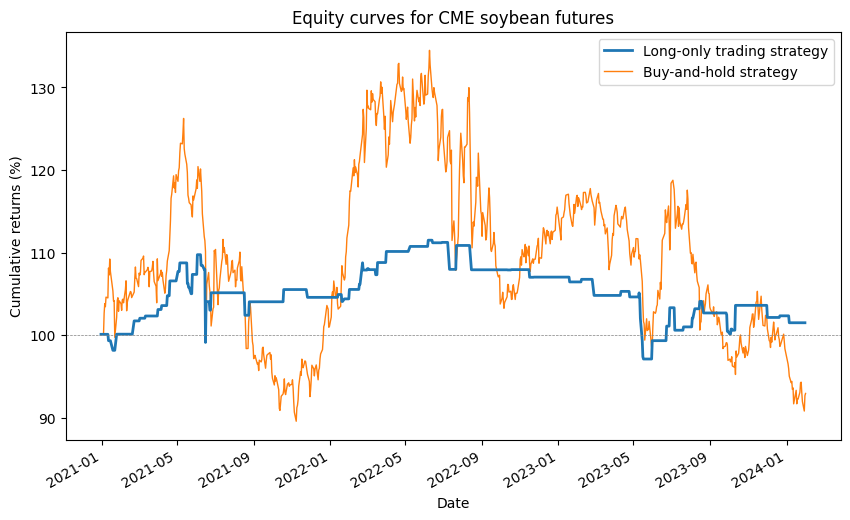

In [50]:
# plot equity curves
plt.figure(figsize=(10, 6))
plt.title(f'Equity curves for CME {ticker_name} futures')
plt.ylabel('Cumulative returns (%)')

# plot long-only strategy
X_test['pnl_long'].plot(label='Long-only trading strategy', linewidth=2)

# plot buy-and-hold strategy
prices['equity'].plot(label='Buy-and-hold strategy', linewidth=1, zorder=0.1)

# add baseline
plt.axhline(y=100, color='grey', linestyle='--', linewidth=0.5)

# display plot
plt.legend()
plt.show()

# Results

- None of the individual models were able to outperform a benchmark model which classified each instance as the positive class.
- However, our ensemble model with default threshold was able to outperform the benchmark model when assessed on the training set.
- After using the validation set to further tune the classification threshold of our ensemble model, we were subsequently also able to outperform the benchmark model when assessed on the test set.
- We finally evaluated the trading performance of our ensemble model, with tuned threshold, on the test set. In a simple long-only trading strategy with a holding period of one day, our ensemble model was able to outperform a buy-and-hold strategy by approximately 10% over a 3-year trading period.

# Next steps

- For the sake of reducing computational requirements, we fixed the number of estimators for both tree-based models at 100. Setting this to a higher number, with some other hyperparameter adjustments such as a lower learning rate, will almost certainly result in more powerful models with better prediction.

- Again, in order to reduce computational overhead, we employed a randomised grid search for hyperparameter tuning. Choosing a Bayesian hyperparameter optimisation algorithm would have resulted in finding a better combination of hyperparameters and thus likely resulting in better prediction.

- The one day holding period and 100% equity allocation to each trade is overly simplistic and we could do better by incorporating measures such rolling volatility and the actual outputted predicted probabilities. For example, when our model is less confident of its prediction, we may choose to allocate less than 100% capital to a trade. And should we already hold a long position, we may choose to stay long whilst our model keeps predicting a positive return for the next trading day.

- The trading performance of our strategy is inflated as we did not take into account transaction fees. A more accurate evaluation will need to incorporate commission, slippage and other fees.

- All of the above code can be easily repurposed to predict negative returns instead. This would require building a second ensemble model, which, to maintain conciseness, we decided not to do. The output of both models could then be put together to build a more sophisticated trading strategy. For example, if both models 'agree', then we allocate more equity to a trade. By 'agree' we mean, for example, our first model is very confidently predicting positive returns, whilst the second model has very little confidence in predicting negative returns for the same period. Additionally, employing both models concurrently would allow our strategy to trade from both the long and short side, increasing trade frequency and potentially also profitability.

- The above code can also be equally applied to other commodities and asset classes. Combining both short and long trading strategies across multiple products and asset classes would allow us to fully benefit from the law of large numbers and diversification.

- Finally, more data is always better. Therefore, if we can obtain data going further back in time, or getting hour/minute/tick level data, we would be able to train more powerful models. Additionally, incorporating other datasets, as well as further feature engineering, would allow us to extract more signal from the noise. Examples of other datasets are, but not limited to, trading data for other commodities, asset classes and indexes, currency exchange rates, interest rates, weather data, etc.

# END

In [51]:
# dependencies
%load_ext watermark
%watermark --python --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

matplotlib: 3.7.1
lightgbm  : 4.1.0
numpy     : 1.23.5
pandas    : 1.5.3
scipy     : 1.11.4
xgboost   : 2.0.3
yfinance  : 0.2.36



**Author: Vladimir Zinkovski**

Send an email: *vladimir.zinkovski@gmail.com*

Or connect with me on: [LinkedIn](https://www.linkedin.com/in/vladimir-zinkovski/)